# Categorização de avaliações

**Passo a passo:**

1. **Pré-processamento**: Remover stop words e aplicar stemming ou lematização
    - Stemming: reduz palavras ao seu radical, ignorando as regras linguísticas (é útil para reduzir a dimensionalidade)
    - Lematização: Reduz palavras à sua forma básica, considerando o contexto gramatical (é mais precisa)
2. **Extração de Características**: Usar TF-IDF ou Word2Vec para criar representações vetoriais das avaliações
    - TF-IDF (term frequence - inverse document frequency) calcula a relevância de cada termo dentro de um documento
    - O Word2Vec captura relações semânticas entre as palavras, criando representações vetoriais densas, que são úteis para capturar o contexto semântico (no entanto, demanda mais recursos computacionais)
3. **Clusterização**: Aplicar K-means para definir categorias com base nas avaliações
    - Após definir os clusters, as categorias podem ser interpretadas extraindo as palavras mais representativas de cada cluster
    - No TF-IDF, isso é feito analisando os pesos de cada termo em cada clsuter
4. **Classificação**: Usar o modelo para categorizar novas avaliações de acordo com as categorias definidas
5. **Avaliação e Ajuste**: Medir a precisão e otimizar o pipeline

## 1. Imports

In [56]:
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import nltk
from nltk.corpus import stopwords
# from nltk.stem import SnowballStemmer

import gensim
from gensim.models import Word2Vec

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# baixar stopwords e pacotes do nltk
# punkt sequence tokenizer = divide um texto em uma lista de sentenças usando um algoritmo não supervisionado para construir um modelo para abreviação de palavras

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('rslp')

In [ ]:
# criar stopwords
stop_words = set(stopwords.words('portuguese'))
len(stop_words)

In [ ]:
# função para stemming
stemmer = nltk.stem.RSLPStemmer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and word.isalpha()]
    return " ".join(tokens)

## 2 Ler base de dados e fazer pre-tratamento

In [11]:
# ler base
df = pd.read_csv('dados/bares_maps/bd-reviews_Reworked.csv')

# remover dicionários vazios
df = df[df['reviews'].notna()]

# extrair nome e comentário do json da coluna de texto
df['name'] = df['reviews'].apply(lambda x: eval(x)['name'])
df['comentario'] = df['reviews'].apply(lambda x: eval(x)['text'])

# selecionar colunas importantes
df = df[['title', 'price', 'categoryName', 'totalScore', 'reviewsCount', 'name', 'comentario']]

# remover os comentários que estão vazios
df = df[df['comentario'].notna()]

# fazer pre-tratamento (remover caracteres especiais e colocar em minúsculo)
df['comentario_tratado'] = df['comentario'].apply(lambda x: re.sub('[^A-Za-z0-9áéíóúàèìòùãõñçâêô ]+', '', x.lower()))

# criar coluna de tamanho do texto
df['tamanho_comentario'] = df['comentario_tratado'].apply(lambda x: len(x))

# aplicar o stemming
df['preprocessed_text'] = df['comentario_tratado'].apply(preprocess_text)
df.head()

,title,price,categoryName,totalScore,reviewsCount,name,comentario,comentario_tratado,tamanho_comentario
0,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Flavia Bruno,"Comida boa, apesar de ser a peso. A mesa de sa...",comida boa apesar de ser a peso a mesa de sala...,257
1,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Cristiane B Monteiro,Gosto demais da variedade da comida. Não tem c...,gosto demais da variedade da comida não tem ch...,163
2,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Joao Laurindo Duarte,"O restaurante vende refeição por quilo, cheque...",o restaurante vende refeição por quilo chequei...,171
3,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Mayannah Hingstone,Ótima opção para almoço no setor Jaó. Grande v...,ótima opção para almoço no setor jaó grande va...,194
4,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Deyvid Linhares,Atendimento excelente!\nComida e preço muito b...,atendimento excelentecomida e preço muito bom ...,100


## 3 Vetorização

### 3.1 TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, max_features = 1000)
X_tfidf = vectorizer.fit_transform(df['preprocessed_text'])

# ver a matriz criada
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns = vectorizer.get_feature_names_out())
X_tfidf_df.head()

### 3.2 Word2Vec

In [51]:
tokenized_reviews = df['preprocessed_text'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences = tokenized_reviews, vector_size = 100, window = 5, min_count = 2, sg = 1)

def get_average_word2vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis = 0) if vectors else np.zeros(100)

df['word2vec_vector'] = df['preprocessed_text'].apply(lambda x: get_average_word2vec(x.split(), word2vec_model))
X_word2vec = np.vstack(df['word2vec_vector'].values)
df.head()

,title,price,categoryName,totalScore,reviewsCount,name,comentario,comentario_tratado,tamanho_comentario,preprocessed_text,word2vec_vector,cluster
0,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Flavia Bruno,"Comida boa, apesar de ser a peso. A mesa de sa...",comida boa apesar de ser a peso a mesa de sala...,257,com boa apes pes mes sal falt rep com sabor em...,"[-0.00066630373, 0.090788126, -0.032208376, -0...",4
1,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Cristiane B Monteiro,Gosto demais da variedade da comida. Não tem c...,gosto demais da variedade da comida não tem ch...,163,gost demal variedad com churrasc outr carn boa...,"[0.037100032, 0.041564666, -0.0316739, -0.0791...",3
2,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Joao Laurindo Duarte,"O restaurante vende refeição por quilo, cheque...",o restaurante vende refeição por quilo chequei...,171,restaurant vend refe quil cheq hor fim dev fec...,"[-0.019541701, 0.099814296, 0.004171444, -0.06...",3
3,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Mayannah Hingstone,Ótima opção para almoço no setor Jaó. Grande v...,ótima opção para almoço no setor jaó grande va...,194,ótim opç almoç set jaó grand variedad com opç ...,"[-0.013724069, -0.0054086316, -0.0090002045, -...",3
4,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Deyvid Linhares,Atendimento excelente!\nComida e preço muito b...,atendimento excelentecomida e preço muito bom ...,100,atend excelentecom preç bom fic pes gram torn ...,"[-0.017467884, 0.0551179, -0.0019956483, -0.06...",3


## 4. Clusterização para a criação de categorias

### 4.1 Elbow method para determinação do número de clusters

Roda o K-means com diferentes quantidades de clusters (k) e plota a soma das distâncias quadradas internas (inertia) para cada valor de k

O "cotovelo" indica o número ideal de clusters (com mais clusters, a inertia não diminui tanto se comparado ao k do cotovelo)

In [53]:
def plot_elbow_method(X, max_k = 10, title = "Elbow Method"):
    inertias = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters = k, random_state = 42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize = (16, 5))
    plt.plot(range(1, max_k + 1), inertias, marker = 'o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title(title)

    # Configura o range do eixo y
    plt.ylim(min(inertias) - 1000, max(inertias) + 1000)

    # Configura o eixo x para ir de 1 em 1
    plt.xticks(range(1, max_k + 1, 1))

    plt.show()

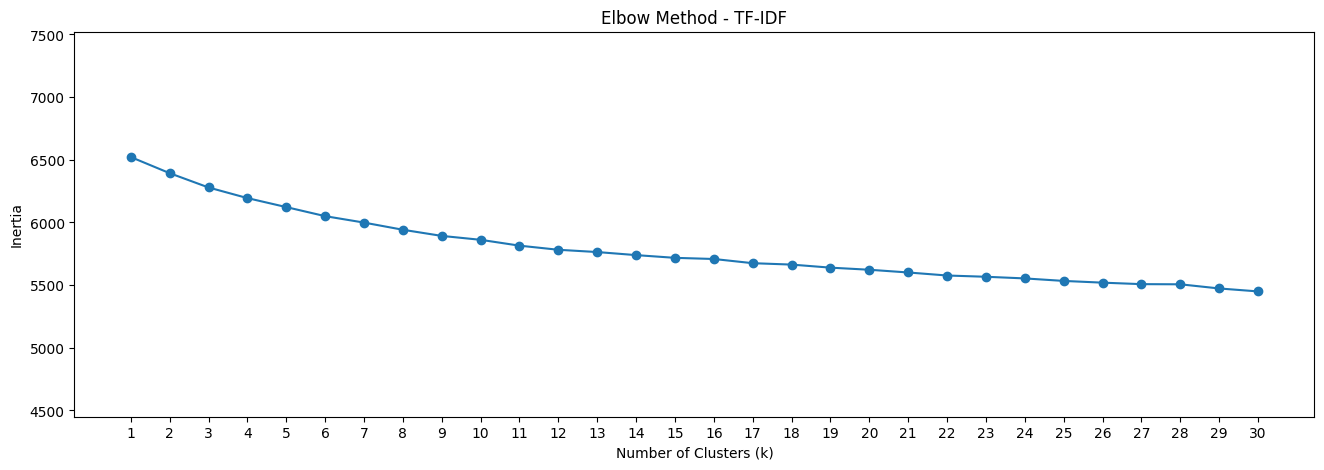

In [58]:
# Para TF-IDF
plot_elbow_method(X_tfidf, max_k = 30, title = "Elbow Method - TF-IDF")

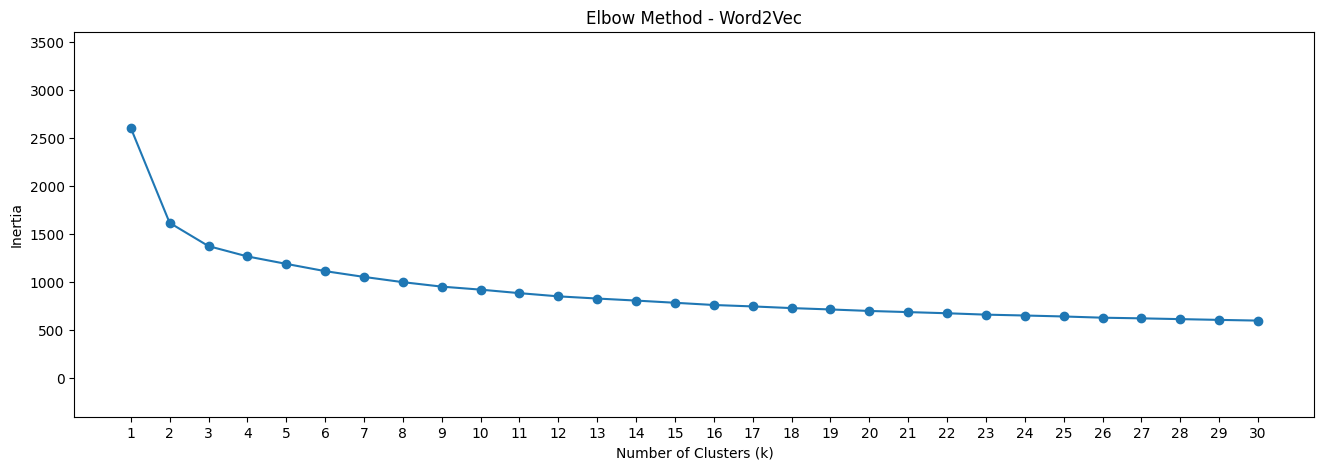

In [57]:
# Para Word2Vec
plot_elbow_method(X_word2vec, max_k = 30, title = "Elbow Method - Word2Vec")

### 4.2 Aplicar k-means

In [62]:
kmeans_tfidf = KMeans(n_clusters = 10, random_state = 42)
df['cluster_tfidf'] = kmeans_tfidf.fit_predict(X_tfidf)

kmeans_word2vec = KMeans(n_clusters = 5, random_state = 42)
df['cluster_word2vec'] = kmeans_word2vec.fit_predict(X_word2vec)

df.head()

,title,price,categoryName,totalScore,reviewsCount,name,comentario,comentario_tratado,tamanho_comentario,preprocessed_text,word2vec_vector,cluster,cluster_tfidf,cluster_word2vec
0,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Flavia Bruno,"Comida boa, apesar de ser a peso. A mesa de sa...",comida boa apesar de ser a peso a mesa de sala...,257,com boa apes pes mes sal falt rep com sabor em...,"[-0.00066630373, 0.090788126, -0.032208376, -0...",4,2,2
1,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Cristiane B Monteiro,Gosto demais da variedade da comida. Não tem c...,gosto demais da variedade da comida não tem ch...,163,gost demal variedad com churrasc outr carn boa...,"[0.037100032, 0.041564666, -0.0316739, -0.0791...",3,8,4
2,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Joao Laurindo Duarte,"O restaurante vende refeição por quilo, cheque...",o restaurante vende refeição por quilo chequei...,171,restaurant vend refe quil cheq hor fim dev fec...,"[-0.019541701, 0.099814296, 0.004171444, -0.06...",3,8,2
3,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Mayannah Hingstone,Ótima opção para almoço no setor Jaó. Grande v...,ótima opção para almoço no setor jaó grande va...,194,ótim opç almoç set jaó grand variedad com opç ...,"[-0.013724069, -0.0054086316, -0.0090002045, -...",3,8,4
4,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Deyvid Linhares,Atendimento excelente!\nComida e preço muito b...,atendimento excelentecomida e preço muito bom ...,100,atend excelentecom preç bom fic pes gram torn ...,"[-0.017467884, 0.0551179, -0.0019956483, -0.06...",3,8,2


### 4.3 Avaliação do modelo

In [22]:
silhouette_score(X_tfidf, kmeans.labels_)

0.01866173709887033

In [40]:
# accuracy
# f1-score

## 5. Classificação das avaliações nas categorias
Exemplo de nova avaliação:

In [24]:
new_review = "Avaliação de exemplo"
preprocessed_review = preprocess_text(new_review)
review_vector = vectorizer.transform([preprocessed_review])  # usando TF-IDF

# Prever o cluster
predicted_cluster = kmeans.predict(review_vector)
predicted_cluster